<a href="https://colab.research.google.com/github/sasika2001/LMS-Sample/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the User Management & Authentication module there is a Multi Agent System. In that MAS there are 4 agents for login authentication part and another 2 agents for user registration part.
Login authentication agents are -
        1. Login Monitor Agent - Monitor login activities of users.
   When login monitor agent detect 3 invalid logins in short time period then call
        2. Admin Alert Agent - Send an alert to the admin
        3. Profile lock Agent - Lock that profile
        4. Anomaly detection agent - Track the login patterns and then try to detect anomalies

User registration agents -
              1. Registration Monotor agent - Monitor User registration
              2. Spelling correct agent -  Correct simple spelling mistakes in userform

Generate Synthetic data set to train Anomaly Detection agent


In [3]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.1 MB/s eta 0:00:00


In [7]:
!pip install pandas

In [9]:
import pandas as pd
from faker import Faker
import random
from datetime import datetime, timedelta

In [13]:
import pandas as pd
from faker import Faker
import random
from datetime import datetime, timedelta

# --- Parameters ---
num_normal_records = 200
num_anomaly_records = 50
total_records = num_normal_records + num_anomaly_records
user_ids = [f"user_{i+1:03d}" for i in range(20)]
normal_ips = [Faker().ipv4() for _ in range(15)]
anomaly_ips = [Faker().ipv4() for _ in range(5)]
user_agents = [Faker().user_agent() for _ in range(5)]

fake = Faker()

# --- Generate Normal Data ---
normal_data = []
for _ in range(num_normal_records):
    user_id = random.choice(user_ids)
    timestamp = fake.date_time_between(start_date='-30d', end_date='now')
    ip_address = random.choice(normal_ips)
    login_status = "Success" if random.random() < 0.95 else "Failure"
    user_agent = random.choice(user_agents)
    normal_data.append([timestamp, user_id, ip_address, login_status, user_agent])

normal_df = pd.DataFrame(normal_data, columns=['timestamp', 'user_id', 'ip_address', 'login_status', 'user_agent'])

# --- Generate Anomalous Data ---
anomaly_data = []

# Anomaly Type 1: Unusual Login Time
for _ in range(int(num_anomaly_records * 0.3)):
    user_id = random.choice(user_ids)
    unusual_hour = random.randint(0, 3)
    timestamp = datetime(2025, 4, random.randint(1, 9), unusual_hour, random.randint(0, 59), random.randint(0, 59))
    ip_address = random.choice(normal_ips + anomaly_ips)
    login_status = "Success"
    user_agent = random.choice(user_agents)
    anomaly_data.append([timestamp, user_id, ip_address, login_status, user_agent])

# Anomaly Type 2: Unfamiliar IP Address
for _ in range(int(num_anomaly_records * 0.3)):
    user_id = random.choice(user_ids)
    timestamp = fake.date_time_between(start_date='-30d', end_date='now')
    ip_address = random.choice(anomaly_ips)
    login_status = "Success"
    user_agent = random.choice(user_agents)
    anomaly_data.append([timestamp, user_id, ip_address, login_status, user_agent])

# Anomaly Type 3: Brute-Force Attempt
suspicious_ip = fake.ipv4()
for _ in range(int(num_anomaly_records * 0.4)):
    user_id = random.choice(user_ids)
    timestamp = fake.date_time_between(start_date='-1d', end_date='now')
    ip_address = suspicious_ip
    login_status = "Failure"
    user_agent = random.choice(user_agents)
    anomaly_data.append([timestamp, user_id, ip_address, login_status, user_agent])
anomaly_data.append([datetime.now(), random.choice(user_ids), suspicious_ip, "Success", random.choice(user_agents)])

anomaly_df = pd.DataFrame(anomaly_data, columns=['timestamp', 'user_id', 'ip_address', 'login_status', 'user_agent'])

# --- Combine and Label ---
synthetic_df = pd.concat([normal_df, anomaly_df])
synthetic_df['is_anomaly'] = [0] * len(normal_df) + [1] * len(anomaly_df)

# --- Shuffle ---
synthetic_df = synthetic_df.sample(frac=1).reset_index(drop=True)

# --- Save to CSV File ---
output_filename = "synthetic_login_data_250.csv"
synthetic_df.to_csv(output_filename, index=False)

print(f"Generated {len(synthetic_df)} synthetic login records and saved them to '{output_filename}'")
print("\nFirst few rows of the generated data:")
print(synthetic_df.head())

Generated 251 synthetic login records and saved them to 'synthetic_login_data_250.csv'

First few rows of the generated data:
                   timestamp   user_id       ip_address login_status  \
0 2025-03-16 10:59:29.232401  user_014   164.38.154.252      Success   
1 2025-03-20 15:28:40.538502  user_014    165.21.77.142      Success   
2 2025-04-08 15:17:38.339569  user_007  100.217.166.141      Failure   
3 2025-04-04 17:25:44.835664  user_004     216.3.158.37      Success   
4 2025-03-10 16:18:53.355015  user_001    72.178.138.75      Success   

                                          user_agent  is_anomaly  
0  Mozilla/5.0 (compatible; MSIE 7.0; Windows NT ...           0  
1  Mozilla/5.0 (compatible; MSIE 7.0; Windows NT ...           0  
2  Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...           1  
3  Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like M...           0  
4  Mozilla/5.0 (compatible; MSIE 7.0; Windows NT ...           0  


Shape of X_train: (175, 5)
Shape of X_test: (76, 5)
Shape of y_train: (175,)
Shape of y_test: (76,)


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# --- 1. Load and Prepare Your Data ---
# Load the dataset (assuming 'synthetic_login_data_250.csv' is uploaded to Colab)
try:
    df = pd.read_csv("synthetic_login_data_250.csv")
except FileNotFoundError:
    print("Error: 'synthetic_login_data_250.csv' not found. Make sure to upload it to Colab.")
    exit()

# Separate features (X) and the target variable (y)
X = df.drop('is_anomaly', axis=1)
y = df['is_anomaly']

# Identify categorical and numerical columns
categorical_cols = ['user_id', 'ip_address', 'login_status', 'user_agent']

# Handle categorical features using Label Encoding
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    X[col] = encoders[col].fit_transform(X[col])

# Handle the timestamp (convert to numerical)
X['timestamp'] = pd.to_datetime(X['timestamp']).astype('int64') // 10**9

# Define numerical columns explicitly (only timestamp after encoding)
numerical_cols = ['timestamp']

# Scale numerical features
if numerical_cols:
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
else:
    print("Warning: No numerical columns to scale.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 2. Initialize and Train the Anomaly Detection Model (Isolation Forest) ---
# Estimate the proportion of anomalies in the training data
contamination = np.sum(y_train == 1) / len(y_train)

# Initialize the Isolation Forest model
model = IsolationForest(contamination=contamination, random_state=42)

# Train the model
model.fit(X_train)

# --- 3. Predict Anomalies on the Test Data ---
# Predict anomalies (-1 for anomaly, 1 for normal)
y_pred_raw_test = model.predict(X_test)

# Convert predictions to binary labels (1 for anomaly, 0 for normal)
y_pred_test_binary = np.where(y_pred_raw_test == -1, 1, 0)

# --- 4. Evaluate the Model ---
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_test_binary)
print(f"Accuracy on the test set: {accuracy:.4f}")

# Print classification report
print("\nClassification Report on the test set:")
print(classification_report(y_test, y_pred_test_binary))

# Calculate AUC
try:
    auc_score = roc_auc_score(y_test, y_pred_test_binary)
    print(f"\nAUC on the test set: {auc_score:.4f}")
except ValueError:
    print("\nAUC cannot be calculated for this prediction.")

print("\nAnomaly detection process complete.")

Accuracy on the test set: 0.7368

Classification Report on the test set:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        56
           1       0.50      0.35      0.41        20

    accuracy                           0.74        76
   macro avg       0.65      0.61      0.62        76
weighted avg       0.71      0.74      0.72        76


AUC on the test set: 0.6125

Anomaly detection process complete.


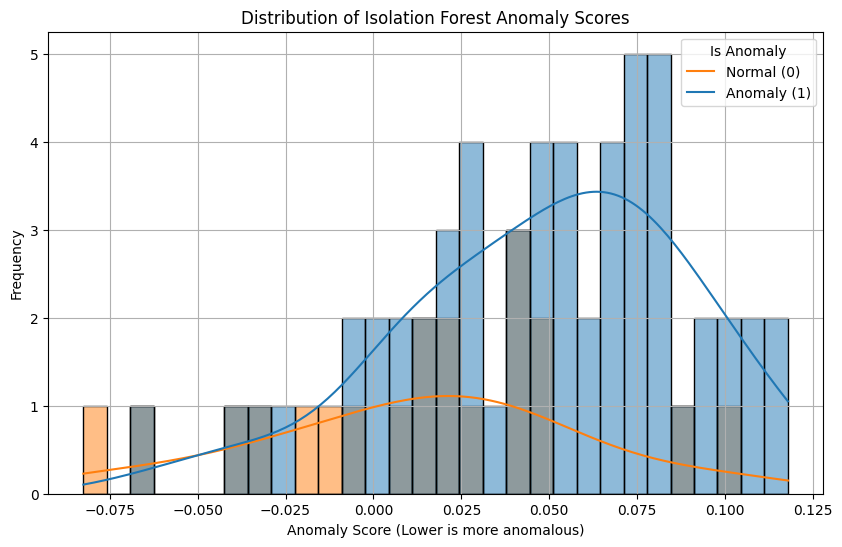

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- 1. Load and Prepare Your Data (as before) ---
try:
    df = pd.read_csv("synthetic_login_data_250.csv")
except FileNotFoundError:
    print("Error: 'synthetic_login_data_250.csv' not found. Make sure to upload it to Colab.")
    exit()

X = df.drop('is_anomaly', axis=1)
y = df['is_anomaly']

categorical_cols = ['user_id', 'ip_address', 'login_status', 'user_agent']
encoders = {col: LabelEncoder().fit_transform(X[col]) for col in categorical_cols}
for col in categorical_cols:
    X[col] = encoders[col]

X['timestamp'] = pd.to_datetime(X['timestamp']).astype('int64') // 10**9
numerical_cols = ['timestamp']
if numerical_cols:
    scaler = StandardScaler().fit(X[numerical_cols])
    X[numerical_cols] = scaler.transform(X[numerical_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 2. Initialize and Train the Model (as before) ---
contamination = np.sum(y_train == 1) / len(y_train)
model = IsolationForest(contamination=contamination, random_state=42)
model.fit(X_train)

# --- 3. Get Anomaly Scores on the Test Data ---
anomaly_scores_test = model.decision_function(X_test)

# Create a DataFrame for visualization
viz_df = pd.DataFrame({'anomaly_score': anomaly_scores_test, 'is_anomaly': y_test})

# --- 4. Plot the Distribution of Anomaly Scores ---
plt.figure(figsize=(10, 6))
sns.histplot(data=viz_df, x='anomaly_score', hue='is_anomaly', kde=True, bins=30)
plt.title('Distribution of Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly Score (Lower is more anomalous)')
plt.ylabel('Frequency')
plt.legend(title='Is Anomaly', labels=['Normal (0)', 'Anomaly (1)'])
plt.grid(True)
plt.show()

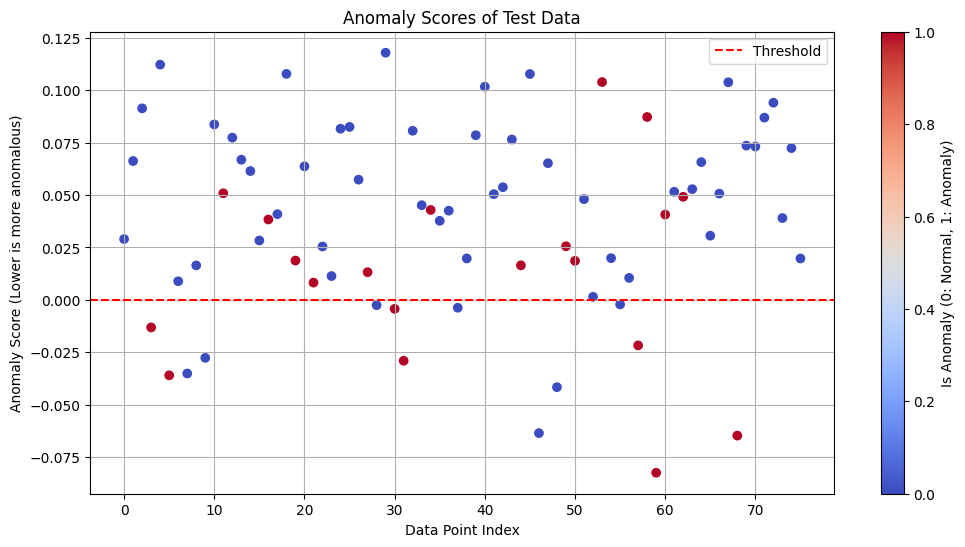

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- 1. Load and Prepare Your Data (as before) ---
try:
    df = pd.read_csv("synthetic_login_data_250.csv")
except FileNotFoundError:
    print("Error: 'synthetic_login_data_250.csv' not found. Make sure to upload it to Colab.")
    exit()

X = df.drop('is_anomaly', axis=1)
y = df['is_anomaly']

categorical_cols = ['user_id', 'ip_address', 'login_status', 'user_agent']
encoders = {col: LabelEncoder().fit_transform(X[col]) for col in categorical_cols}
for col in categorical_cols:
    X[col] = encoders[col]

X['timestamp'] = pd.to_datetime(X['timestamp']).astype('int64') // 10**9
numerical_cols = ['timestamp']
if numerical_cols:
    scaler = StandardScaler().fit(X[numerical_cols])
    X[numerical_cols] = scaler.transform(X[numerical_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 2. Initialize and Train the Model (as before) ---
contamination = np.sum(y_train == 1) / len(y_train)
model = IsolationForest(contamination=contamination, random_state=42)
model.fit(X_train)

# --- 3. Get Anomaly Scores and Predictions on the Test Data ---
anomaly_scores_test = model.decision_function(X_test)
y_pred_test_binary = np.where(model.predict(X_test) == -1, 1, 0)

# --- 4. Create a DataFrame for Visualization ---
viz_df = pd.DataFrame({'anomaly_score': anomaly_scores_test, 'is_anomaly': y_test, 'prediction': y_pred_test_binary, 'index': range(len(y_test))})

# --- 5. Create the Scatter Plot ---
plt.figure(figsize=(12, 6))
scatter = plt.scatter(viz_df['index'], viz_df['anomaly_score'], c=viz_df['is_anomaly'], cmap='coolwarm') # 'coolwarm' distinguishes better

# Add a threshold line (you might need to adjust this based on your scores)
threshold = 0  # A common threshold for Isolation Forest's decision_function
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score (Lower is more anomalous)')
plt.title('Anomaly Scores of Test Data')
plt.colorbar(scatter, label='Is Anomaly (0: Normal, 1: Anomaly)')
plt.legend()
plt.grid(True)
plt.show()